# **Proyecto: Macroeconometría 2023-I (UdeP)**
## Predicción de la inflación de junio 2023 usando un modelo VAR
Por Enrique Sánchez

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import chi2
from scipy.stats import jarque_bera
from matplotlib import pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.stats.diagnostic import acorr_lm, linear_lm

from sklearn.metrics import mean_squared_error # pip install sklearn
from pylab import rcParams

## Definicion de DataFrames

In [2]:
baseDF = pd.read_excel('dataema.xlsx')
baseDF = baseDF.set_index(["Fecha"])

baseDF['log_Petroleo'] = np.log(baseDF['P. Petroleo'])
baseDF['log_M1'] = np.log(baseDF['M1'])

baseDF = baseDF.drop(['IPC'], axis=1)
baseDF = baseDF.drop(['P. Petroleo'], axis=1)
baseDF = baseDF.drop(['M1'], axis=1)

baseDF

,Expect,TC,IPC%,log_Petroleo,log_M1
Fecha,,,,,
2003-01-01,1.975000,3.48075,0.231420,3.494991,8.506915
2003-02-01,2.408333,3.47960,0.468825,3.578786,8.505732
2003-03-01,2.537500,3.47370,1.117780,3.511844,8.519256
2003-04-01,2.633333,3.46140,-0.050857,3.338258,8.521280
2003-05-01,2.550000,3.49520,-0.032025,3.336125,8.538585
...,...,...,...,...,...
2023-01-01,4.622917,3.84670,0.226447,4.383401,11.246565
2023-02-01,4.291667,3.80570,0.294523,4.344455,11.254878
2023-03-01,4.300000,3.76210,1.253487,4.326382,11.243392


## Graficos de variables

In [3]:
def plotGraphs(df, column):
    plt.plot(df.index, df[column])
    plt.title("Grafico de "+ column+ " vs Fecha")
    plt.xlabel("Fecha")
    plt.ylabel(column)
    plt.show()

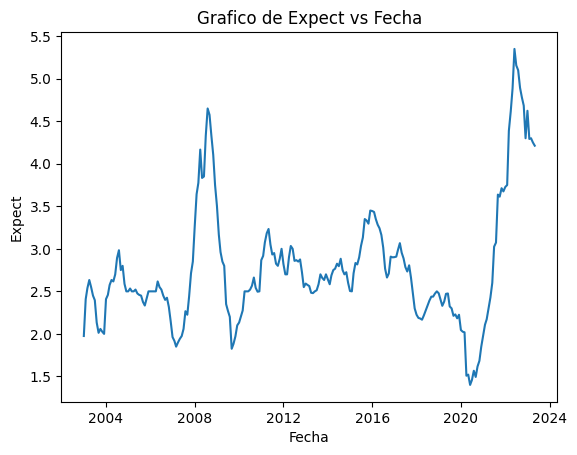

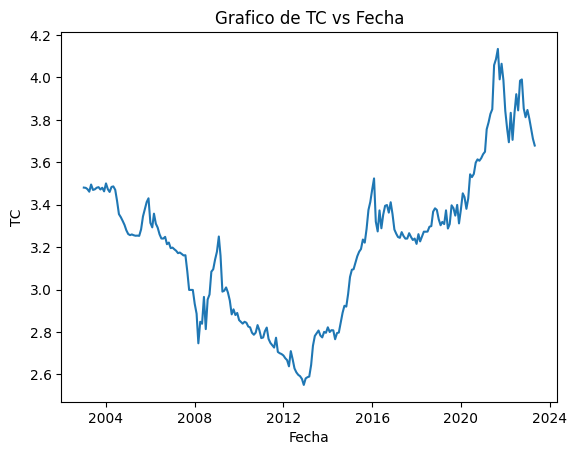

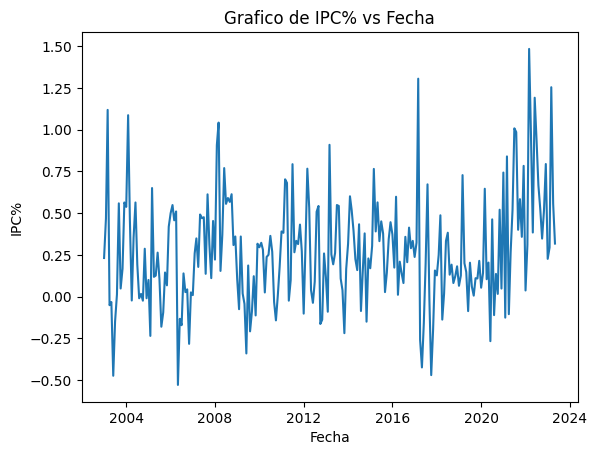

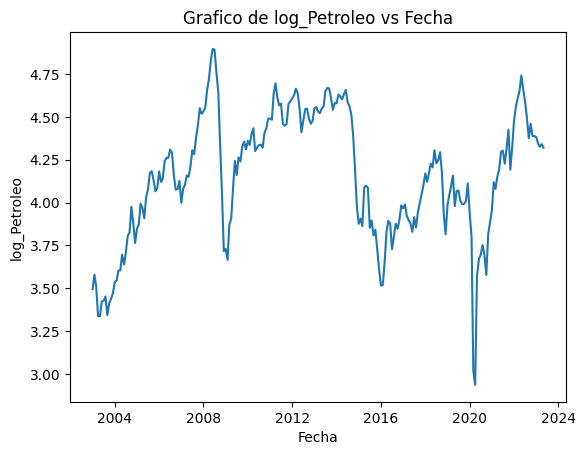

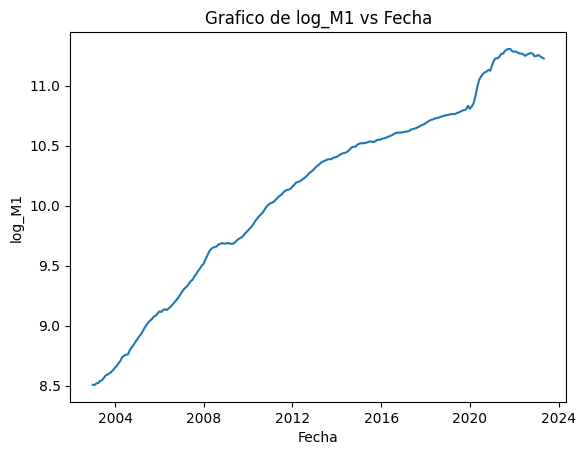

In [4]:
for column in baseDF.columns:
    plotGraphs(baseDF, column)

## Decomposicion Aditiva por Temporada

In [5]:
PERIODOS = 6

In [6]:
def aditiveDecomp(df, column):
    rcParams['figure.figsize'] = 12,8
    decomposition = sm.tsa.seasonal_decompose(df[column], model='additive', period=PERIODOS)
    fig = decomposition.plot()
    plt.show()

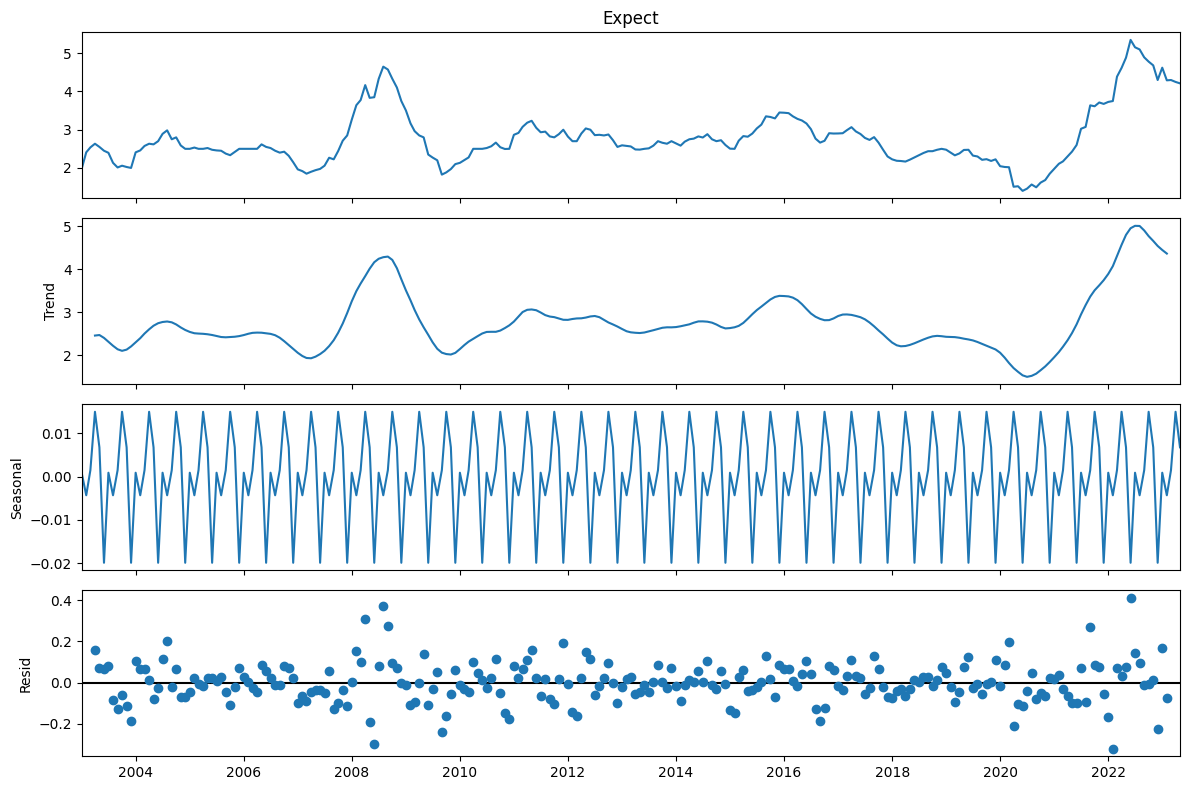

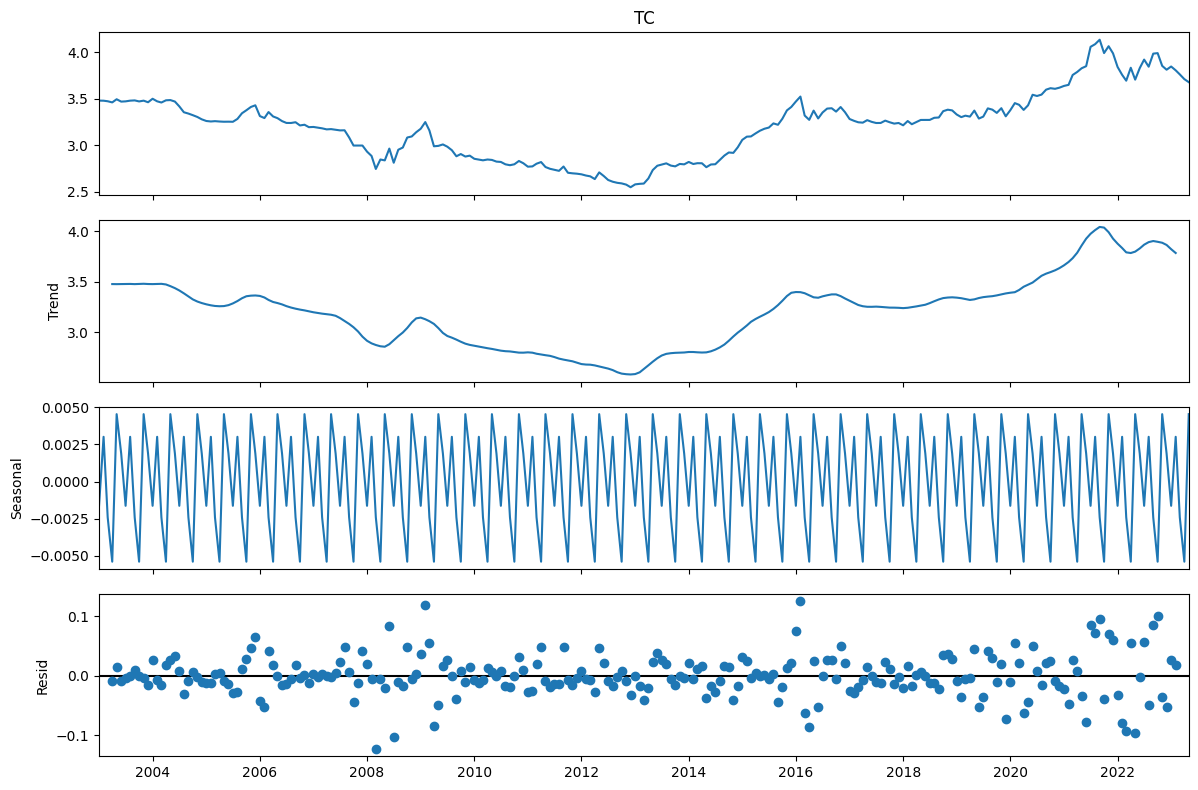

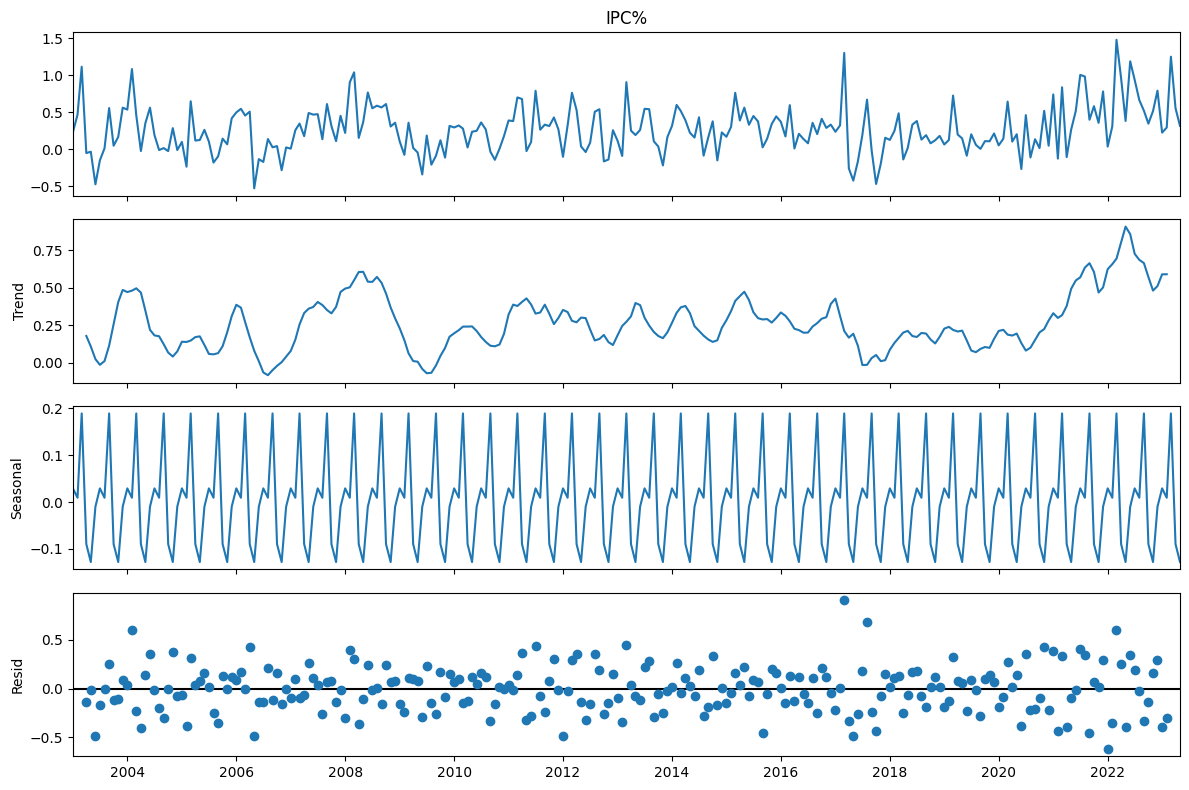

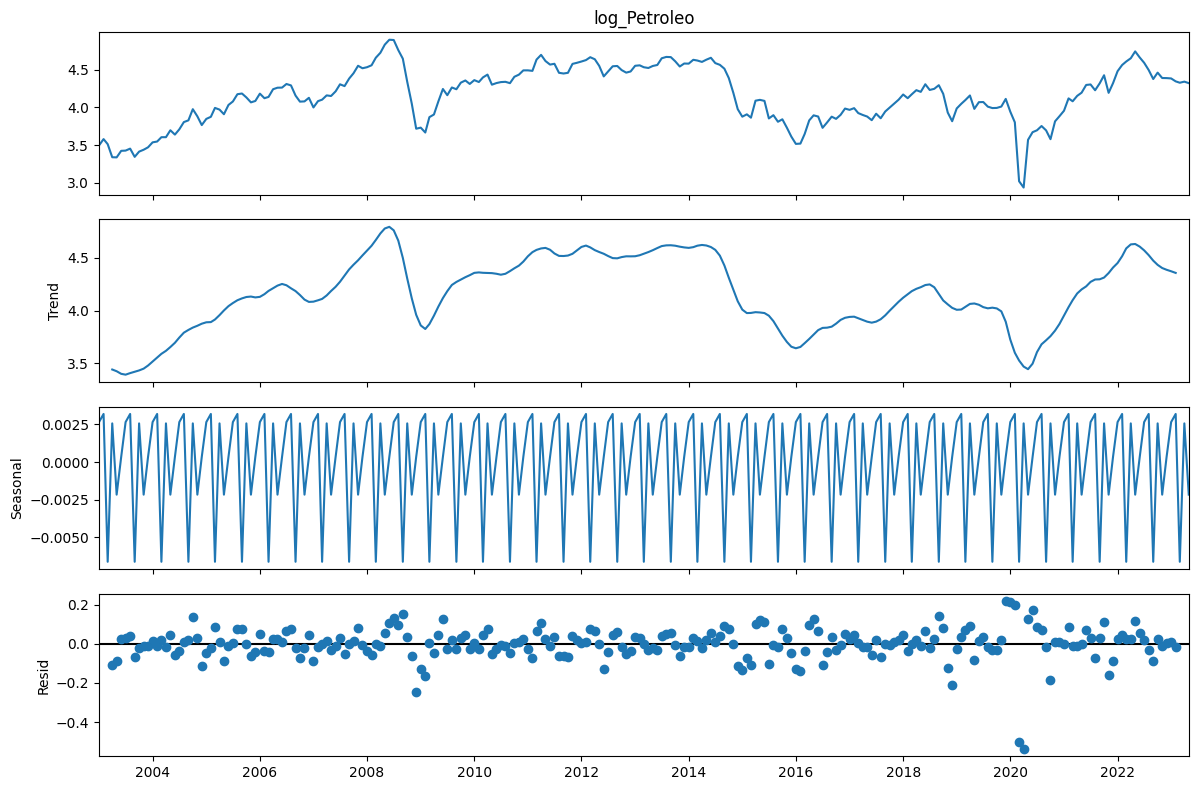

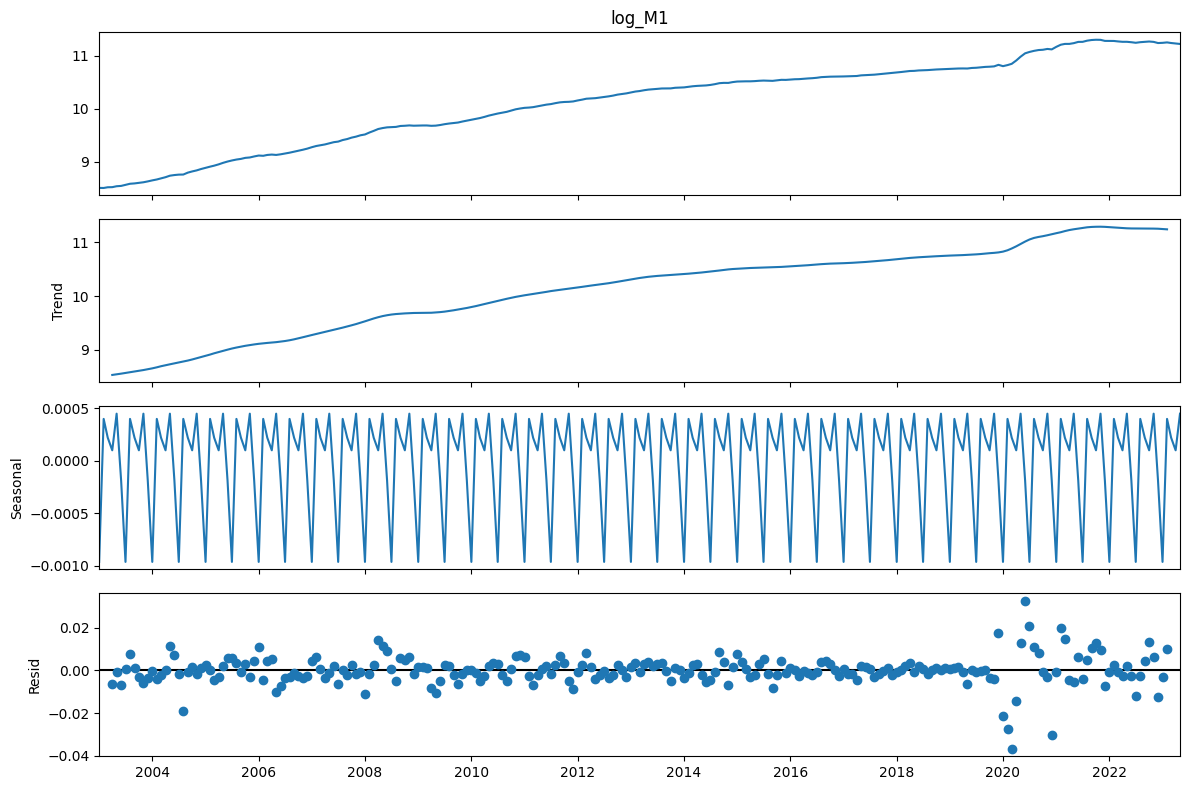

In [7]:
for column in baseDF.columns:
    aditiveDecomp(baseDF, column)

## Dividimos la data en Entrenamiento y Testeo

In [8]:
TESTINGPERCENT = 38

separacion = int(len(baseDF) * TESTINGPERCENT/100)

def divData(df, n):
    df_train, df_test = df[0:-n], df[-n:]

    # Check size
    print("Training set shape: ", df_train.shape)
    print("Testing set shape: ", df_test.shape)

    return df_train, df_test

In [9]:
trainDF, testDF = divData(baseDF, separacion)

Training set shape:  (152, 5)
Testing set shape:  (93, 5)


## ADF/ NG-Perron Tests 

### ADF Test

In [10]:
# Codigo recuperado de https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print("Null Hypothesis: Data has unit root. Non-Stationary.")
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(" => Series is Non-Stationary.") 

    return p_value

In [11]:
for name in baseDF.columns:
    if name != 'TC':
        adfuller_test(trainDF[name], name=name)
        print('\n')

    Augmented Dickey-Fuller Test on "Expect" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.8432
 No. Lags Chosen       = 10
 Critical value 1%     = -3.478
 Critical value 5%     = -2.882
 Critical value 10%    = -2.578
 => P-Value = 0.0025. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "IPC%" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.6753
 No. Lags Chosen       = 0
 Critical value 1%     = -3.474
 Critical value 5%     = -2.881
 Critical value 10%    = -2.577
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "log_Petroleo" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Le

### Test NG-Perron 

In [12]:
def ng_perron_test(x):
    n = len(x)
    k = int(np.sqrt(n))

    x_diff = np.diff(x)
    x_diff_lagged = [np.roll(x_diff, i) for i in range(k+1)]

    X = np.column_stack(x_diff_lagged)
    X = sm.add_constant(X)
    model = sm.OLS(x_diff, X)
    results = model.fit()

    lm_stat = n * results.rsquared
    p_value = 1 - chi2.cdf(lm_stat, k)

    print(f"Ng-Perron test\n p-value = {p_value}")

    return p_value

In [13]:
print("Ng-Perron Test for TC:")
ng_perron_test(trainDF['TC'])

Ng-Perron Test for TC:
Ng-Perron test
 p-value = 0.0


0.0

## Calculamos primeras diferencias

In [14]:
difTrainDF = trainDF.diff().dropna()
difTrainDF

,Expect,TC,IPC%,log_Petroleo,log_M1
Fecha,,,,,
2003-02-01,0.433333,-0.00115,0.237405,0.083794,-0.001183
2003-03-01,0.129167,-0.00590,0.648955,-0.066942,0.013524
2003-04-01,0.095833,-0.01230,-1.168637,-0.173586,0.002024
2003-05-01,-0.083333,0.03380,0.018832,-0.002132,0.017305
2003-06-01,-0.100000,-0.02535,-0.441104,0.086833,0.006121
...,...,...,...,...,...
2015-04-01,0.120833,0.03210,-0.374158,0.225326,-0.000068
2015-05-01,-0.016667,0.02910,0.173859,0.011173,0.003963
2015-06-01,0.083333,0.02150,-0.232024,-0.013860,0.006319


## Corremos tests en las versiones diferenciadas


### ADF Test

In [15]:
segundasDiferencias = False

for name in baseDF.columns:
    if name != 'TC':
        p_value = adfuller_test(difTrainDF[name], name=name)

        if(p_value > 0.05):
            segundasDiferencias = True

        print('\n')

    Augmented Dickey-Fuller Test on "Expect" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.8007
 No. Lags Chosen       = 14
 Critical value 1%     = -3.479
 Critical value 5%     = -2.883
 Critical value 10%    = -2.578
 => P-Value = 0.0029. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "IPC%" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.6494
 No. Lags Chosen       = 3
 Critical value 1%     = -3.476
 Critical value 5%     = -2.881
 Critical value 10%    = -2.577
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "log_Petroleo" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Le

### NG-Perron Test

In [16]:
print("Ng-Perron Test for TC:")
ng_perron_test(difTrainDF['TC'])

Ng-Perron Test for TC:
Ng-Perron test
 p-value = 0.0


0.0

## Revisamos si es necesario aplicar segundas diferencias

In [17]:
if (segundasDiferencias):
    difTrainDF = difTrainDF.diff().dropna()
    difTrainDF

In [18]:
if segundasDiferencias:
    for name in difTrainDF.columns:
        if name != 'TC':
            adfuller_test(difTrainDF[name], name=name)
            print('\n')

In [19]:
if segundasDiferencias:
    ng_perron_test(difTrainDF['TC'])

## Elegimos orden del modelo VAR

In [20]:
def selectOrder(model):

    aic     = {"best_value": 1000000, "best_lag": 0, "local_best": False}
    bic     = {"best_value": 1000000, "best_lag": 0, "local_best": False}
    fpe     = {"best_value": 1000000, "best_lag": 0, "local_best": False}
    hqic    = {"best_value": 1000000, "best_lag": 0, "local_best": False}

    localBestHQIC    = False

    for i in range(1,8):
        result = model.fit(i)
        print('Lag order = ', i)
        print('AIC : ', result.aic)
        print('BIC : ', result.bic)
        print('FPE : ', result.fpe)
        print('HQIC: ', result.hqic, '\n')

        if result.aic < aic["best_value"] and not aic["local_best"]:
            aic["best_lag"] = i
            aic["best_value"] = result.aic
        else:
            aic["local_best"] = True

        if result.bic < bic["best_value"] and not bic["local_best"]:
            bic["best_lag"] = i
            bic["best_value"] = result.bic
        else:
            bic["local_best"] = True

        if result.fpe < fpe["best_value"] and not fpe["local_best"]:
            fpe["best_lag"] = i
            fpe["best_value"] = result.fpe
        else:
            fpe["local_best"] = True

        if result.hqic < hqic["best_value"] and not hqic["local_best"]:
            hqic["best_lag"] = i
            hqic["best_value"] = result.hqic
        else:
            hqic["local_best"] = True

    print("The first lowest AIC value was: ", aic["best_value"], " using lag ", aic["best_lag"])
    print("The first lowest BIC value was: ", bic["best_value"], " using lag ", bic["best_lag"])
    print("The first lowest FPE value was: ", fpe["best_value"], " using lag ", fpe["best_lag"])
    print("The first lowest HQIC value was: ", hqic["best_value"], " using lag ", hqic["best_lag"])

    minResult = min(aic["best_value"],bic["best_value"],fpe["best_value"],hqic["best_value"])

    if aic["best_value"] == minResult:
        return aic["best_lag"]
    if bic["best_value"] == minResult:
        return bic["best_lag"]
    if fpe["best_value"] == minResult:
        return fpe["best_lag"]
    if hqic["best_value"] == minResult:
        return hqic["best_lag"]

In [21]:
model = VAR(difTrainDF)

lags = selectOrder(model)

print("Number of lags selected: ", lags)

Lag order =  1
AIC :  -27.345469932302848
BIC :  -26.743342873483595
FPE :  1.3307793153117128e-12
HQIC:  -27.100844847396242 

Lag order =  2
AIC :  -27.73951746850002
BIC :  -26.63067822805035
FPE :  8.98390243260529e-13
HQIC:  -27.289014415780283 

Lag order =  3
AIC :  -27.742622217709318
BIC :  -26.12250747513412
FPE :  8.982025703429054e-13
HQIC:  -27.084373340194965 

Lag order =  4
AIC :  -27.78056364958773
BIC :  -25.644540373317202
FPE :  8.696159513960044e-13
HQIC:  -26.912674225668837 

Lag order =  5
AIC :  -27.694665684996206
BIC :  -25.038029651968234
FPE :  9.565207308154812e-13
HQIC:  -26.6152136231004 

Lag order =  6
AIC :  -27.631013114880684
BIC :  -24.448987390224207
FPE :  1.0340723036306924e-12
HQIC:  -26.33804843722168 

Lag order =  7
AIC :  -27.710897621708067
BIC :  -23.998630997238067
FPE :  9.745802758775302e-13
HQIC:  -26.20244193689489 

The first lowest AIC value was:  -27.78056364958773  using lag  4
The first lowest BIC value was:  -26.743342873483595

C:\Users\kikes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## Entrenamos el modelo VAR

In [22]:
model_fitted = model.fit(lags)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 27, Jun, 2023
Time:                     12:13:41
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -25.6445
Nobs:                     147.000    HQIC:                  -26.9127
Log likelihood:           1103.95    FPE:                8.69616e-13
AIC:                     -27.7806    Det(Omega_mle):     4.46034e-13
--------------------------------------------------------------------
Results for equation Expect
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  -0.026376         0.024849           -1.061           0.288
L1.Expect               0.239516         0.087846            2.727           0.006
L1.TC                  -0.422044         0.244139  

## Autocorrelation Test


### Durbin-Watson Test

In [23]:
autocorrelation = durbin_watson(model_fitted.resid)

for col, val in zip(difTrainDF.columns, autocorrelation):
    if len(col) < 10:
        print(col, "\t\t:\t", round(val, 2))
    else:
        print(col, "\t:\t", round(val, 2))

Expect 		:	 2.01
TC 		:	 2.02
IPC% 		:	 2.02
log_Petroleo 	:	 2.07
log_M1 		:	 2.01


### LM Test

In [24]:
print("LM Test for:")

for col in model_fitted.resid.columns:
    autocorrelation = acorr_lm(model_fitted.resid[col])
    if len(col) < 10:
        print(col, "\t\t:\t", round(autocorrelation[0], 2))
    else:
        print(col, "\t:\t", round(autocorrelation[0], 2))


LM Test for:
Expect 		:	 7.14
TC 		:	 13.3
IPC% 		:	 12.51
log_Petroleo 	:	 6.21
log_M1 		:	 4.19


## Granger Causality Test    

In [25]:
# Codigo recuperado de https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

def grangers_causation_matrix(data, variables, test='ssr_chi2test', maxlag= lags, verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df    

In [26]:
grangers_causation_matrix(difTrainDF, difTrainDF.columns)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=148, df_num=1
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1
parameter F test:         F=25.5203 , p=0.0000  , df_denom=148, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=146, df_num=2
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=2
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=2
parameter F test:         F=12.5465 , p=0.0000  , df_denom=146, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=144, df_num=3
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=3
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=3
parameter F test:         F=9.0970  , p=0.0000  , df_denom=144, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0000  , p=1.0000  

,Expect_x,TC_x,IPC%_x,log_Petroleo_x,log_M1_x
Expect_y,1.0000,0.0001,0.0000,0.0071,0.0135
TC_y,0.2489,1.0000,0.0474,0.0093,0.0153
IPC%_y,0.1533,0.1562,1.0000,0.3367,0.1346
log_Petroleo_y,0.1484,0.0017,0.2389,1.0000,0.1896
log_M1_y,0.0264,0.0000,0.2773,0.0568,1.0000


## Test de Normalidad (Jarque-Bera)

In [27]:
stat, pvalue = stats.jarque_bera(difTrainDF)
print(stat,pvalue)

2817.7697346218943 0.0


## Testeamos predicciones usando el modelo VAR entrenado

In [28]:
lag_order = model_fitted.k_ar
print(lag_order) 

forecast_input = difTrainDF.values[-lag_order:]
forecast_input

4


array([[-0.01666667,  0.0291    ,  0.17385894,  0.0111733 ,  0.00396296],
       [ 0.08333333,  0.0215    , -0.23202408, -0.01386012,  0.00631912],
       [ 0.13333333,  0.0126    ,  0.11844504, -0.23277444,  0.00396091],
       [ 0.1       ,  0.0447    , -0.07356027,  0.04319608, -0.00213354]])

In [29]:
juneEntry = pd.DataFrame.from_dict(data={"Fecha": ['2023-06-01'], 'Expect': [None], 'TC': [None], 'IPC%': [None], "log_Petroleo": [None], "log_M1":[None]})
juneEntry = juneEntry.set_index("Fecha")
juneEntry

juneEntry.index = pd.to_datetime(juneEntry.index)
resultDF = pd.concat([baseDF, juneEntry])
resultDF

,Expect,TC,IPC%,log_Petroleo,log_M1
Fecha,,,,,
2003-01-01,1.975000,3.48075,0.231420,3.494991,8.506915
2003-02-01,2.408333,3.47960,0.468825,3.578786,8.505732
2003-03-01,2.537500,3.47370,1.117780,3.511844,8.519256
2003-04-01,2.633333,3.46140,-0.050857,3.338258,8.521280
2003-05-01,2.550000,3.49520,-0.032025,3.336125,8.538585
...,...,...,...,...,...
2023-02-01,4.291667,3.80570,0.294523,4.344455,11.254878
2023-03-01,4.300000,3.76210,1.253487,4.326382,11.243392
2023-04-01,4.250000,3.71110,0.556252,4.340944,11.233286


In [30]:
if segundasDiferencias:
    diferencias = '_2d'
else:
    diferencias = '_1d'

prediccion = model_fitted.forecast(y=forecast_input, steps=separacion+1)
forecastDF = pd.DataFrame(prediccion, index=resultDF.index[-separacion-1:], columns=baseDF.columns + diferencias)
    
forecastDF

,Expect_1d,TC_1d,IPC%_1d,log_Petroleo_1d,log_M1_1d
Fecha,,,,,
2015-09-01,-0.028913,0.012919,0.027777,-0.082808,0.003390
2015-10-01,0.015779,0.022581,-0.107268,-0.025423,0.005710
2015-11-01,-0.065086,0.001541,-0.112435,-0.048572,0.005519
2015-12-01,-0.107491,0.014263,0.113825,-0.049348,0.005218
2016-01-01,-0.078463,0.001380,-0.067144,-0.023722,0.006984
...,...,...,...,...,...
2023-02-01,0.000353,-0.001246,0.000121,0.001891,0.013090
2023-03-01,0.000353,-0.001246,0.000121,0.001891,0.013090
2023-04-01,0.000353,-0.001246,0.000121,0.001891,0.013090


In [31]:
# Fragmento recuperado de https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [32]:
resultsDF = invert_transformation(trainDF, forecastDF, second_diff= segundasDiferencias)
resultsDF.loc[:, ['Expect_forecast', 'TC_forecast', 'IPC%_forecast', 'log_Petroleo_forecast', 'log_M1_forecast']]

,Expect_forecast,TC_forecast,IPC%_forecast,log_Petroleo_forecast,log_M1_forecast
Fecha,,,,,
2015-09-01,3.104420,3.248819,0.405003,3.813086,10.535379
2015-10-01,3.120199,3.271400,0.297735,3.787663,10.541089
2015-11-01,3.055113,3.272941,0.185300,3.739092,10.546608
2015-12-01,2.947621,3.287204,0.299124,3.689744,10.551826
2016-01-01,2.869158,3.288584,0.231980,3.666022,10.558810
...,...,...,...,...,...
2023-02-01,2.371934,3.144108,0.215851,3.844678,11.642884
2023-03-01,2.372287,3.142862,0.215972,3.846569,11.655975
2023-04-01,2.372640,3.141616,0.216093,3.848460,11.669065


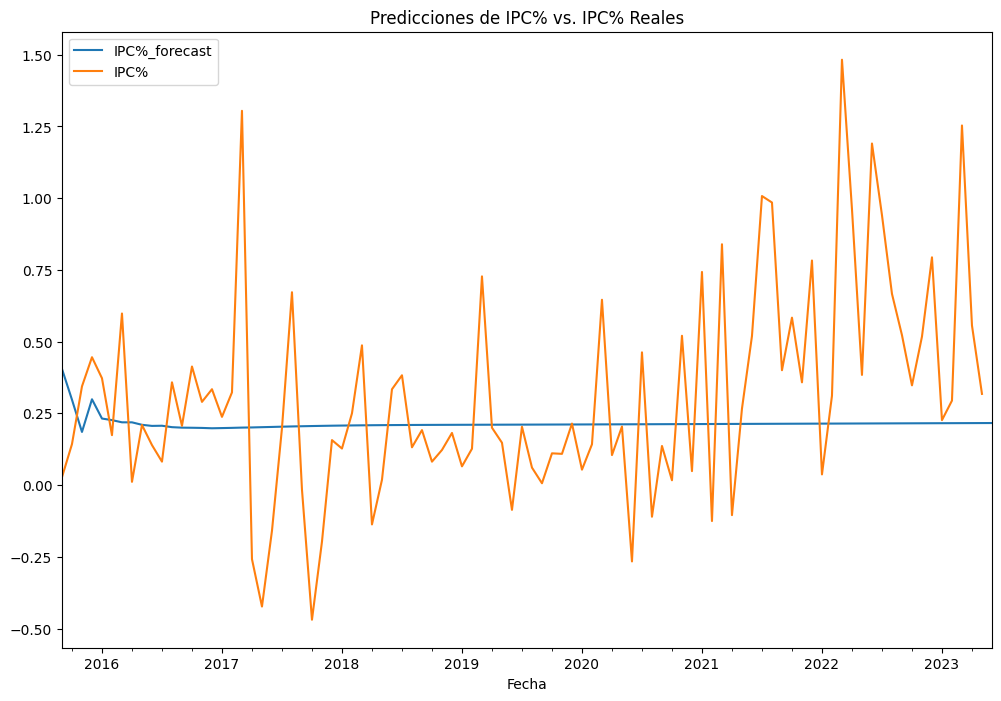

In [33]:
resultsDF["IPC%_forecast"].plot().autoscale(axis='x',tight=True)
testDF["IPC%"].plot().autoscale(axis="x", tight=True)

plt.legend()
plt.title("Predicciones de IPC% vs. IPC% Reales")
plt.show()

Prediccion Final para Junio 2023:

In [34]:
print('IPC%' + " Esperado para Junio 2023:", resultsDF.loc["2023-06-01", "IPC%_forecast"])

IPC% Esperado para Junio 2023: 0.21633591786480258


In [35]:
for name in resultsDF.columns:
    if '_1d' in name:
        resultsDF = resultsDF.drop([name], axis=1)

for name in resultsDF.columns:
    if '_2d' in name:
        resultsDF = resultsDF.drop([name], axis=1)

mse = mean_squared_error(testDF,resultsDF[:-1])
print(f'mse modelo VAR: {mse}')

mse modelo VAR: 0.3338394914681225


## Bibliografia

- https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
- https://www.youtube.com/watch?v=OvpQeHuXBVY&ab_channel=IvyProSchool